Processing gene UL33...
Alignment for UL33 already exists. Reading file data/fasta/aligned_UL33.fasta.
Processing gene UL78...
Alignment for UL78 already exists. Reading file data/fasta/aligned_UL78.fasta.
Processing gene US27...
Alignment for US27 already exists. Reading file data/fasta/aligned_US27.fasta.
Processing gene US28...
Alignment for US28 already exists. Reading file data/fasta/aligned_US28.fasta.


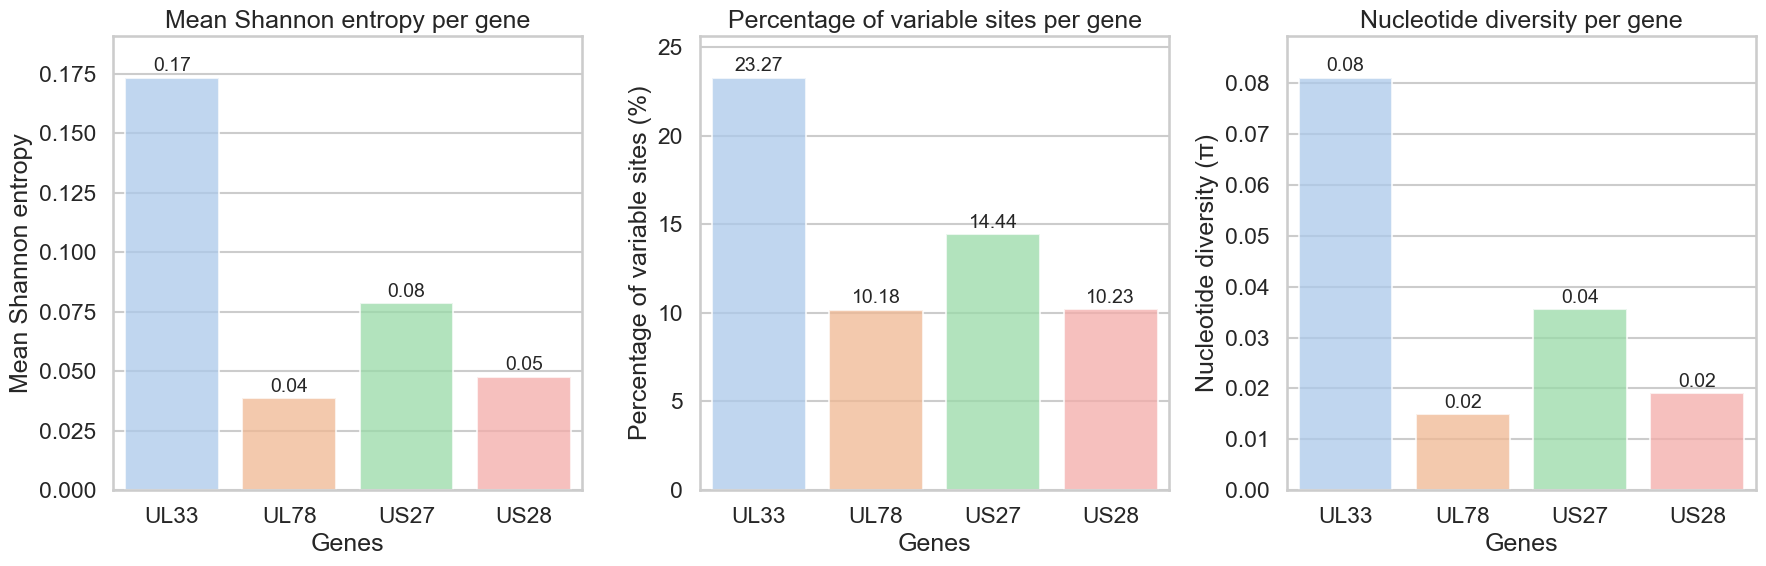

In [1]:
import os
import subprocess
from Bio import SeqIO
from Bio import AlignIO
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns  # To improve the aesthetics of the plots

# Apply a general style to the plots
sns.set(style='whitegrid', context='talk')

def read_sequences(file):
    """Read sequences from a FASTA file."""
    sequences = [record for record in SeqIO.parse(file, "fasta")]
    return sequences

def align_sequences(muscle_path, input_fasta, output_fasta):
    """Align sequences using MUSCLE."""
    # Construct the MUSCLE command
    command = f'"{muscle_path}" -in "{input_fasta}" -out "{output_fasta}" -maxiters 100'
    print(f"Executing command: {command}")
    
    try:
        # Run the command
        subprocess.run(command, check=True, shell=True, text=True, stderr=subprocess.PIPE)
        print(f"MUSCLE succeeded for {input_fasta}")
    except subprocess.CalledProcessError as e:
        # Handle errors and display stderr output
        print(f"Error running MUSCLE for {input_fasta}: {e.stderr}")

def read_alignment(alignment_file):
    """Read an alignment from a file."""
    alignment = AlignIO.read(alignment_file, 'fasta')
    return alignment

def alignment_to_array(alignment):
    """Convert an alignment to a NumPy array."""
    alignment_array = np.array([list(rec.seq) for rec in alignment], dtype='S1')
    return alignment_array

def calculate_entropy(alignment_array):
    """Calculate Shannon entropy at each position."""
    num_sequences, alignment_length = alignment_array.shape
    entropies = []
    
    for i in range(alignment_length):
        column = alignment_array[:, i]
        # Convert to strings
        column = np.char.decode(column.astype('S1'), 'utf-8')
        unique, counts = np.unique(column, return_counts=True)
        frequencies = counts / num_sequences
        
        # Exclude gaps ('-') from calculations
        freq_dict = dict(zip(unique, frequencies))
        if '-' in freq_dict:
            del freq_dict['-']
        
        # Calculate Shannon entropy
        shannon_entropy = -sum(freq * np.log2(freq) for freq in freq_dict.values() if freq > 0)
        entropies.append(shannon_entropy)
    
    return entropies

def calculate_variable_site_percentage(alignment_array, variability_threshold=0.01):
    """Calculate the percentage of variable sites."""
    num_sequences, alignment_length = alignment_array.shape
    variable_sites = 0
    
    for i in range(alignment_length):
        column = alignment_array[:, i]
        # Convert to strings
        column = np.char.decode(column.astype('S1'), 'utf-8')
        unique, counts = np.unique(column, return_counts=True)
        max_count = max(counts)
        proportion_different = 1 - (max_count / num_sequences)
        
        if proportion_different > variability_threshold:
            variable_sites += 1
            
    variable_site_percentage = (variable_sites / alignment_length) * 100
    return variable_site_percentage

def calculate_nucleotide_diversity(alignment_array):
    """Calculate nucleotide diversity (π)."""
    num_sequences, alignment_length = alignment_array.shape
    total_diff = 0
    num_pairs = 0
    
    # Create all combinations of sequence pairs
    for seq1, seq2 in itertools.combinations(alignment_array, 2):
        # Convert to strings
        seq1 = np.char.decode(seq1.astype('S1'), 'utf-8')
        seq2 = np.char.decode(seq2.astype('S1'), 'utf-8')
        diffs = np.sum(seq1 != seq2)
        total_diff += diffs
        num_pairs += 1

    # Calculate nucleotide diversity
    pi = total_diff / (alignment_length * num_pairs)
    return pi

def process_gene(gene_name, file, muscle_path, variability_threshold=0.01):
    """Process a gene to calculate variability measures."""
    # Alignment file
    alignment_file = f'data/fasta/aligned_{gene_name}.fasta'
    
    # Check if the alignment file already exists
    if os.path.exists(alignment_file):
        print(f"Alignment for {gene_name} already exists. Reading file {alignment_file}.")
    else:
        # Read sequences from the file
        sequences = read_sequences(file)
        
        if len(sequences) > 1:
            # Temporary input file
            temp_input = f'temp_input_{gene_name}.fasta'
            
            # Write the sequences to the temporary input file
            SeqIO.write(sequences, temp_input, "fasta")
            
            # Align the sequences with MUSCLE
            align_sequences(muscle_path, temp_input, alignment_file)
            
            # Remove the temporary file
            os.remove(temp_input)
        else:
            # If only one sequence, copy the original file
            SeqIO.write(sequences, alignment_file, "fasta")
    
    # Read the alignment
    alignment = read_alignment(alignment_file)
    
    # Convert the alignment to a NumPy array
    alignment_array = alignment_to_array(alignment)
    
    # Calculate Shannon entropy at each position
    entropies = calculate_entropy(alignment_array)
    
    # Calculate the average variability (mean entropy)
    mean_entropy = np.mean(entropies)
    
    # Calculate the percentage of variable sites
    variable_site_percentage = calculate_variable_site_percentage(alignment_array, variability_threshold)
    
    # Calculate nucleotide diversity (π)
    nucleotide_diversity = calculate_nucleotide_diversity(alignment_array)
    
    return mean_entropy, variable_site_percentage, nucleotide_diversity

def plot_results(gene_names, mean_entropies, variable_site_percentages, nucleotide_diversities):
    """Plot the variability measures."""
    # Combine the three plots into a single figure with three columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Color palette for the bars
    colors = sns.color_palette('pastel', n_colors=len(gene_names))
    
    # 1. Mean Variability (Mean Entropy)
    sns.barplot(x=gene_names, y=mean_entropies, ax=axes[0], hue=gene_names, dodge=False, palette=colors, alpha=0.75)
    axes[0].set_xlabel('Genes')
    axes[0].set_ylabel('Mean Shannon entropy')
    axes[0].set_title('Mean Shannon entropy per gene')
    axes[0].tick_params(axis='x', rotation=0)
    axes[0].set_ylim(0, max(mean_entropies) * 1.1)  # Adjust ylim
    if axes[0].legend_ is not None:
        axes[0].legend_.remove()
    
    # Annotate the bars with the exact values
    for p in axes[0].patches:
        axes[0].annotate(f'{p.get_height():.2f}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 8), 
                         textcoords='offset points',
                         fontsize=14)
    
    # 2. Percentage of Variable Sites
    sns.barplot(x=gene_names, y=variable_site_percentages, ax=axes[1], hue=gene_names, dodge=False, palette=colors, alpha=0.75)
    axes[1].set_xlabel('Genes')
    axes[1].set_ylabel('Percentage of variable sites (%)')
    axes[1].set_title('Percentage of variable sites per gene')
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].set_ylim(0, max(variable_site_percentages) * 1.1)  # Adjust ylim
    if axes[1].legend_ is not None:
        axes[1].legend_.remove()
    
    # Annotate the bars with the exact values
    for p in axes[1].patches:
        axes[1].annotate(f'{p.get_height():.2f}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 8), 
                         textcoords='offset points',
                         fontsize=14)
    
    # 3. Nucleotide Diversity (π)
    sns.barplot(x=gene_names, y=nucleotide_diversities, ax=axes[2], hue=gene_names, dodge=False, palette=colors, alpha=0.75)
    axes[2].set_xlabel('Genes')
    axes[2].set_ylabel('Nucleotide diversity (π)')
    axes[2].set_title('Nucleotide diversity per gene')
    axes[2].tick_params(axis='x', rotation=0)
    axes[2].set_ylim(0, max(nucleotide_diversities) * 1.1)  # Adjust ylim
    if axes[2].legend_ is not None:
        axes[2].legend_.remove()
    
    # Annotate the bars with the exact values
    for p in axes[2].patches:
        axes[2].annotate(f'{p.get_height():.2f}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 8), 
                         textcoords='offset points',
                         fontsize=14)
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    
    # Save the combined figure
    plt.savefig('fig/figure_variability_measures.pdf', dpi=300)
    plt.savefig('fig/figure_variability_measures.png', dpi=300)
    
    # Show the figure
    plt.show()

def main():
    """Main function to process genes and plot results."""
    # Path to the MUSCLE executable
    muscle_path = './lib/muscle.exe'  # Replace with the actual path
    
    gene_files = [
        {'gene_name': 'UL33', 'file': 'data/fasta/UL33_all_nucleotide_sequences_annotated.fasta'},
        {'gene_name': 'UL78', 'file': 'data/fasta/UL78_nucleotide_sequences.fasta'},
        {'gene_name': 'US27', 'file': 'data/fasta/US27_nucleotide_sequences.fasta'},
        {'gene_name': 'US28', 'file': 'data/fasta/US28_nucleotide_sequences.fasta'}
    ]
    
    mean_entropies = []
    variable_site_percentages = []
    nucleotide_diversities = []
    gene_names = []
    
    for gene_info in gene_files:
        gene_name = gene_info['gene_name']
        file = gene_info['file']
        print(f"Processing gene {gene_name}...")
        mean_entropy, variable_site_percentage, nucleotide_diversity = process_gene(gene_name, file, muscle_path)
        mean_entropies.append(mean_entropy)
        variable_site_percentages.append(variable_site_percentage)
        nucleotide_diversities.append(nucleotide_diversity)
        gene_names.append(gene_name)
    
    plot_results(gene_names, mean_entropies, variable_site_percentages, nucleotide_diversities)

if __name__ == '__main__':
    main()